In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
PATH_OF_DATA='/content/gdrive/"My Drive"/tennis'
!ls {PATH_OF_DATA}

backhand  forehand  serve  test


Visualize the dataset

303


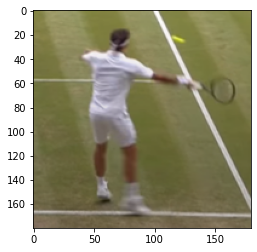

In [ ]:
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import glob as glob
import numpy as np
import tensorflow as tf

image_count = len(list(glob.glob('/content/gdrive/My Drive/tennis/*/*.png')))
print(image_count)

forehand = list(glob.glob('/content/gdrive/My Drive/tennis/forehand/*.png'))

img1 = PIL.Image.open(str(forehand[10]))
img1_resized = img1.resize((180, 180))
plt.imshow(img1_resized)


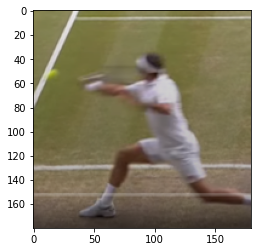

In [ ]:
backhand = list(glob.glob('/content/gdrive/My Drive/tennis/backhand/*.png'))

img2 = PIL.Image.open(str(backhand[0]))
img2_resized = img2.resize((180, 180))
plt.imshow(img2_resized)

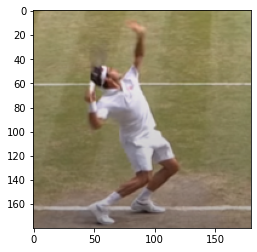

In [ ]:

serve = list(glob.glob('/content/gdrive/My Drive/tennis/serve/*.png'))

img3 = PIL.Image.open(str(serve[10]))
img3_resized = img3.resize((180, 180))
plt.imshow(img3_resized)


Set the batch size, image height and width

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
data_dir = '/content/gdrive/My Drive/tennis'

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 303 files belonging to 3 classes.
Using 243 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 303 files belonging to 3 classes.
Using 60 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['backhand', 'forehand', 'serve']


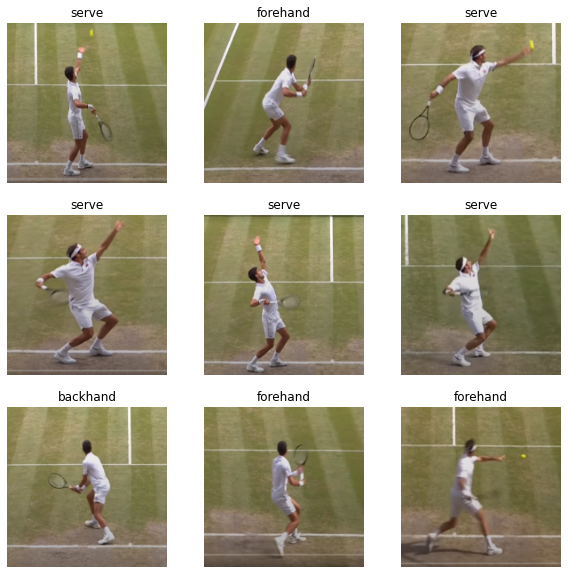

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.013062819 0.98823535


The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a relu activation function. 

In [ ]:
num_classes = 3

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
features, labels = next(iter(train_ds))

tf.Tensor(
[[[[144.14195  131.38638   90.38639 ]
   [152.03722  140.94666   99.98917 ]
   [163.29167  152.51805  112.291664]
   ...
   [130.28334  124.50971   72.4861  ]
   [130.33528  125.24083   72.70029 ]
   [129.52779  125.20306   72.2975  ]]

  [[139.42416  128.09834   86.8575  ]
   [147.03334  136.18916   95.63917 ]
   [155.93333  144.93333  104.933334]
   ...
   [133.56667  127.495834  75.60001 ]
   [133.96083  127.83332   75.63831 ]
   [133.91501  127.67417   75.915   ]]

  [[139.54445  129.54445   87.29305 ]
   [146.54445  136.09444   95.54444 ]
   [154.73611  143.73611  103.736115]
   ...
   [135.35417  128.75002   77.868065]
   [135.       128.29027   77.47222 ]
   [135.84999  128.92917   78.32221 ]]

  ...

  [[121.07917  104.630554  88.630554]
   [122.240295 106.00279   89.7903  ]
   [123.111145 106.58336   90.4653  ]
   ...
   [107.47221   92.        72.47221 ]
   [107.79305   91.480576  72.243065]
   [107.15835   90.15835   71.15835 ]]

  [[121.86668  104.90917   88.1925

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)
  return loss_object(y_true=y, y_pred=y_)


l = loss(model, features, labels, training=False)
print("Loss test: {}".format(l))

Loss test: 1.0967457294464111


In [ ]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels, training=True).numpy()))

Step: 0, Initial Loss: 1.086775779724121
Step: 1,         Loss: 1.0884525775909424


In [ ]:
# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 15

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in train_ds:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(y, model(x, training=True))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                              epoch_loss_avg.result(),
                                                              epoch_accuracy.result()))

Epoch 000: Loss: 1.082, Accuracy: 43.621%


Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
8/8 [==============================] - 11s 1s/step - loss: 0.2383 - accuracy: 0.9177 - val_loss: 0.4881 - val_accuracy: 0.8167
Epoch 2/15
8/8 [==============================] - 7s 831ms/step - loss: 0.1648 - accuracy: 0.9506 - val_loss: 0.4845 - val_accuracy: 0.8167
Epoch 3/15
8/8 [==============================] - 7s 828ms/step - loss: 0.1079 - accuracy: 0.9671 - val_loss: 0.4441 - val_accuracy: 0.8667
Epoch 4/15
8/8 [==============================] - 7s 829ms/step - loss: 0.0756 - accuracy: 0.9794 - val_loss: 0.4576 - val_accuracy: 0.8333
Epoch 5/15
8/8 [==============================] - 7s 822ms/step - loss: 0.0613 - accuracy: 0.9835 - val_loss: 0.5351 - val_accuracy: 0.8000
Epoch 6/15
8/8 [==============================] - 7s 830ms/step - loss: 0.0497 - accuracy: 0.9877 - val_loss: 0.4941 - val_accuracy: 0.8833
Epoch 7/15
8/8 [==============================] - 7s 829ms/step - loss: 0.0281 - accuracy: 0.9959 - val_loss: 0.5548 - val_accuracy: 0.8333
Epoch 8/15
8/8 [======

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

Visualize training results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predict on new data

This image most likely belongs to forehand with a 50.45 percent confidence.


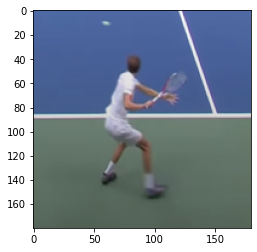

In [ ]:
test_path = "/content/gdrive/My Drive/test/test9.png"


img1 = PIL.Image.open(test_path)
img1_resized = img1.resize((180, 180))
plt.imshow(img1_resized)

img = keras.preprocessing.image.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)